# ID5059 P2 --- Group Project

In [140]:
# project set-up
import sys
!{sys.executable} -m pip install numpy missingno calmap pandas matplotlib imbalanced-learn rpy2 scikit-learn seaborn | grep -v 'already satisfied'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import calmap 
import missingno as msno

from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 1. Data Exploration and Cleaning

R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/corrplot_0.92.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3765850 bytes (3.6 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

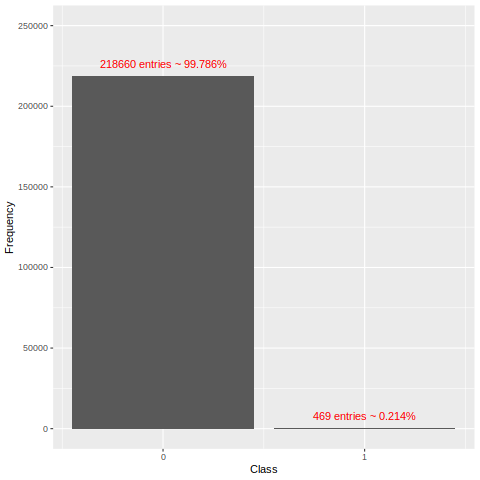

In [291]:
%%R
install.packages("corrplot", repos='http://cran.us.r-project.org')
library(tidyverse)

# Loads in Train and Testing Data Sets

train <- read.csv("/cs/studres/ID5059/Coursework/Coursework-2/data/train.csv")

test <- read.csv("/cs/studres/ID5059/Coursework/Coursework-2/data/test.csv")
  

# Structure of Train

#### Correlations In Train ####

# gets correlation matrix of training data
cor_mat_train <- cor(train)

# Produces a correlation plot of the training data 

corrplot::corrplot(cor_mat_train)

# gets correlations between Class and each variable
class_cors_train <- cor_mat_train[,32][-32]

# makes data frame of variables and their correlations with class
correlations_with_class <- data.frame(
  
  Variable=names(class_cors_train),
  Correlation_With_Class= unname(class_cors_train) 
  
) 

# Plots these correlations in descending order of absolute value  
ggplot(correlations_with_class,aes(x=reorder(Variable, -abs(Correlation_With_Class)),y=Correlation_With_Class)) +
  geom_bar(stat="identity") +
  ylab("Correlation with Class") +
  xlab("Variable")

# Finds the Number of Entries of Each Class
num_class_train <- train %>%
  group_by(Class) %>%
  summarize(Frequency=n(),Label=paste(n(),"entries",paste0("~ ",round(100* n()/dim(train)[1],4),"%")))

# Plots the number of entries of each class type
ggplot(num_class_train,aes(x=Class,y=Frequency,label = Label))+
  geom_bar(stat="identity") +
  geom_text(vjust=-1,colour = "red") +
  ylim(c(0,250000)) +
  ylab("Frequency") +
  scale_x_continuous(breaks=c(0,1))

First want to examine correlations between variables in the training dataset so I found the correlation matrix of the data set and then made a correlation plot of all of the variables. 

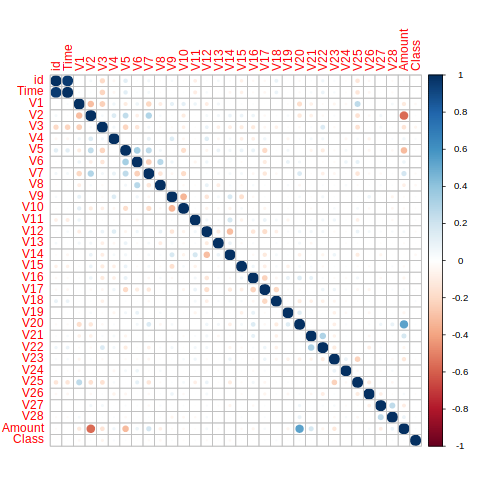

In [122]:
%%R
# Structure of Train

#### Correlations In Train ####

# gets correlation matrix of training data
cor_mat_train <- cor(train)

# Produces a correlation plot of the training data 

corrplot::corrplot(cor_mat_train)


I then wanted to examine what variables in particular Class is most correlated with. I showed this information by plotting a bar chart of the variables that are most correlated with class in descending order of absolute value. 

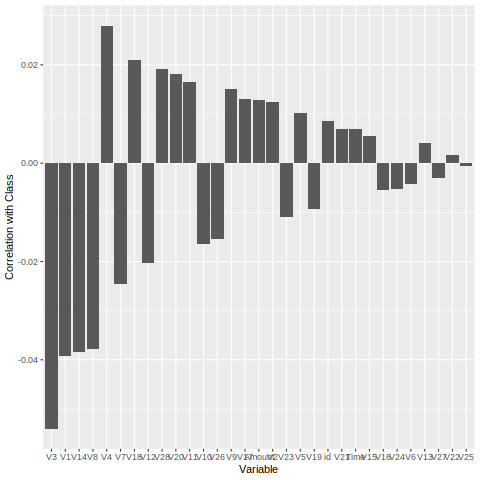

In [124]:
%%R
# gets correlations between Class and each variable
class_cors_train <- cor_mat_train[,32][-32]

# makes data frame of variables and their correlations with class
correlations_with_class <- data.frame(
  
  Variable=names(class_cors_train),
  Correlation_With_Class= unname(class_cors_train) 
  
  
) 

# Plots these correlations in descending order of absolute value  
ggplot(correlations_with_class,aes(x=reorder(Variable, -abs(Correlation_With_Class)),y=Correlation_With_Class)) +
  geom_bar(stat="identity") +
  ylab("Correlation with Class") +
  xlab("Variable")

I then wanted to see how many entries each type of Class had so I plotted a labelled bar chart which displayed this information. 

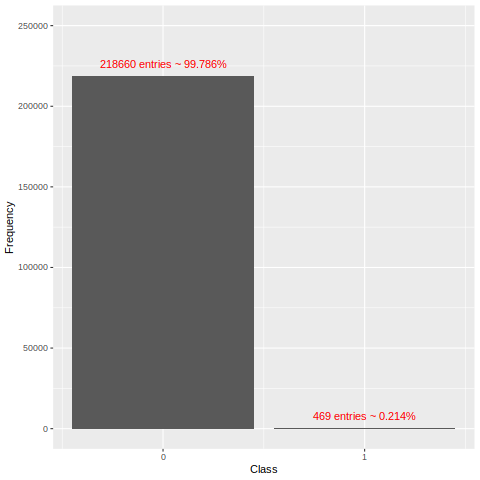

In [125]:
%%R

# Finds the Number of Entries of Each Class
num_class_train <- train %>%
  group_by(Class) %>%
  summarize(Frequency=n(),Label=paste(n(),"entries",paste0("~ ",round(100* n()/dim(train)[1],4),"%")))

# Plots a labelled bar chart showing the number of entries of each class type
ggplot(num_class_train,aes(x=Class,y=Frequency,label = Label))+
  geom_bar(stat="identity") +
  geom_text(vjust=-1,colour = "red") +
  ylim(c(0,250000)) +
  ylab("Frequency") +
  scale_x_continuous(breaks=c(0,1))


Now that I have explored the structure of the training dataset I want to see if the feature distributions of the training and testing datasets are similiar 

I now want to remove the outliers from my training dataset. My first step was to create a function which takes a vector labels each entry as either an outlier or not an outlier for the values within that vector. I used the criterion that an outlier is an observation which is at least 6 standard deviations away from the mean of the vector. 

In [127]:
%%R

#### Removing Outliers and Assessing Results ####

# A function which takes a vector of numeric values and returns
# a vector Of true/false values indicating which values
# in the vector could be considered outliers

identify_outlier <- function(vector){
  
  # Finds the Mean and Standard Deviation of a Vector
  mean <- mean(vector)
  sd <- sd(vector)
  
  # Identifies Upper and Lower Bounds of Reasonable Values 
  # For Values in Vector
  upper <- mean+6*sd
  lower <- mean-6*sd
  
  # All V Variables have minimum less than 0
  if(min(vector)>=0){
    
    upper <- quantile(vector,0.99)+6*sd
    lower <- 0
    
  }
  
  # Identifies Elements of Vector Which are Outside 
  # of These Bounds of a Reasonable Value
  condition <- vector > upper  | vector < lower
  
  return(condition)
  
}

I then created a function which takes a dataframe and applies the previous function to each variable of a dataframe individually and creates a label of either outlier or not outlier for each entry of the dataframe. I also created another function to be used in conjunction with this that gives the names of the variables within that dataframe that an observation is an outlier in (if any).

In [128]:
%%R

# A function which takes a data frame and outputs a vector of true/false values 
# indicating if an entry can be considered an outlier for any of the variables 
# within the data frame

dataframe_is_outlier <- function(dataframe){
  
  # applies identify_outlier across all columns of the data
  condition <- apply(dataframe,2,identify_outlier)
  
  # finds the row sums of this new data frame and if any are more than 0 
  # it returns a true 
  return(apply(condition,1,sum)>0)

}

# A function which takes a vector and returns the a string of the 
# column names of the entries of the vector which are true 

what_cols <- function(vector){
  
  return(paste(names(vector[vector==TRUE]),sep=", "))
  
  
}

I then created a function which takes a dataframe and gives which variable each entry is an outlier in (if any). This helps me identify how good my outlier criterion is. 

In [129]:
%%R

# A function which takes a data frame and produces a vector indicating which columns 
# each entry could be considered an outlier for (if any) 

outlier_diagnosis <- function(dataframe){
  
  # applies identify_outlier across all columns
  condition <- apply(dataframe,2,identify_outlier)
  
  # applies what_cols across all rows
  return(apply(condition,1,what_cols))
  
}


I applied each of these functions to the training dataset which means I now have the training dataset with 2 new columns. One identifying if an observation is an outlier and the other identifying what variables it is an outlier in.

I subsetted this new data to find only the observations that were outliers. I also wanted to make sure I was not removing any observation with Class=1 as there were very few of them so I removed these observations from this new dataset.   

In [130]:
%%R
# removes columns from data which cannot contain outliers
train_minus <- train %>%
  dplyr::select(-c(id,Time,Class))

# identifies outliers of training dataset that are not of Class 1 
train_identified_outlier <- train %>%
  
  # adds two columns: one identifying if an entry is an outlier and
  # the other identifying which variables it is an outlier for 
  mutate(outlier=dataframe_is_outlier(train_minus),
         what_col=outlier_diagnosis(train_minus)) %>%
  
  # Filters only for entries which are outliers
  filter(outlier==TRUE) %>%
  
  # filters for class = 1 
  filter(Class != 1)



I then removed the outliers from the original training data

In [131]:
%%R


# Stores the ID of the outlier data in the Training Data Set
outliers_ID <- train_identified_outlier$id

# Stores the Number of Outliers
number_of_outliers <- length(outliers_ID)

# Creates a New Data Set With The Outliers Removed
train_outliers_removed <- train %>%
                            filter(!(id %in% outliers_ID))
  

# Stores only V variables of train
train_vs_only <- train %>%
  dplyr::select(-c(Time,id,Amount,Class))

# Stores only V Variables For Class = 0 
train_vs_only_0 <- train %>%
  filter(Class==0) %>%
  dplyr::select(-c(Time,id,Amount,Class))

# Stores Only V variables for data with no poutliers
train_vs_only_no_outliers <- train_outliers_removed %>%
  filter(Class==0) %>%
  dplyr::select(-c(Time,id,Amount,Class))

I wanted to then check if I had successfully removed the outliers within my data so I created a boxplot of the V variables in my data with the outliers removed and then I also plotted a histogram of amount as this was not possible to plot on the boxplot. 

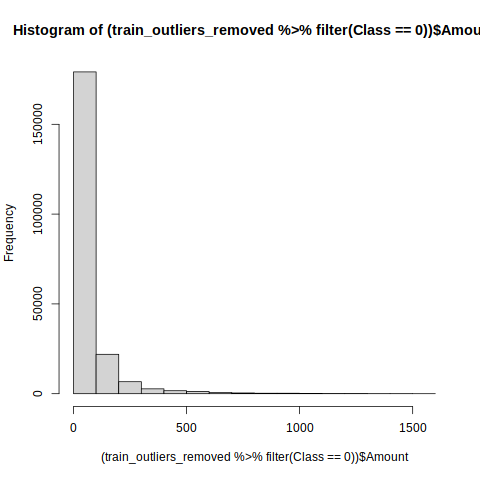

In [132]:
%%R
# Plots Amount Variable for class = 0 with outliers in and removed
hist((train_outliers_removed %>% filter(Class==0))$Amount)

I then exported the data with the outliers removed from R as a .csv so that it could be used in the modelling process which was done in Python

In [133]:
%%R
write.csv(train_outliers_removed, "train_set_no_outliers.csv", row.names=FALSE)

# Data Imputation

In [135]:
#Read file
df = pd.read_csv('/cs/studres/ID5059/Coursework/Coursework-2/data/train.csv')

Generate Random Missing Values.

In [136]:
# Create a new column for original V1 values
df['V1_original'] = df['V1']

In [137]:
# Generate random missing values on column V1
mask = np.random.choice([True, False], size=df['V1'].shape, p=[0.1, 0.9])
mask[mask.all(),-1] = 0
df['V1'] = df['V1'].mask(mask)

In [138]:
#Detecting missing values
df.isnull().sum()

id                 0
Time               0
V1             21625
V2                 0
V3                 0
V4                 0
V5                 0
V6                 0
V7                 0
V8                 0
V9                 0
V10                0
V11                0
V12                0
V13                0
V14                0
V15                0
V16                0
V17                0
V18                0
V19                0
V20                0
V21                0
V22                0
V23                0
V24                0
V25                0
V26                0
V27                0
V28                0
Amount             0
Class              0
V1_original        0
dtype: int64

<Axes: >

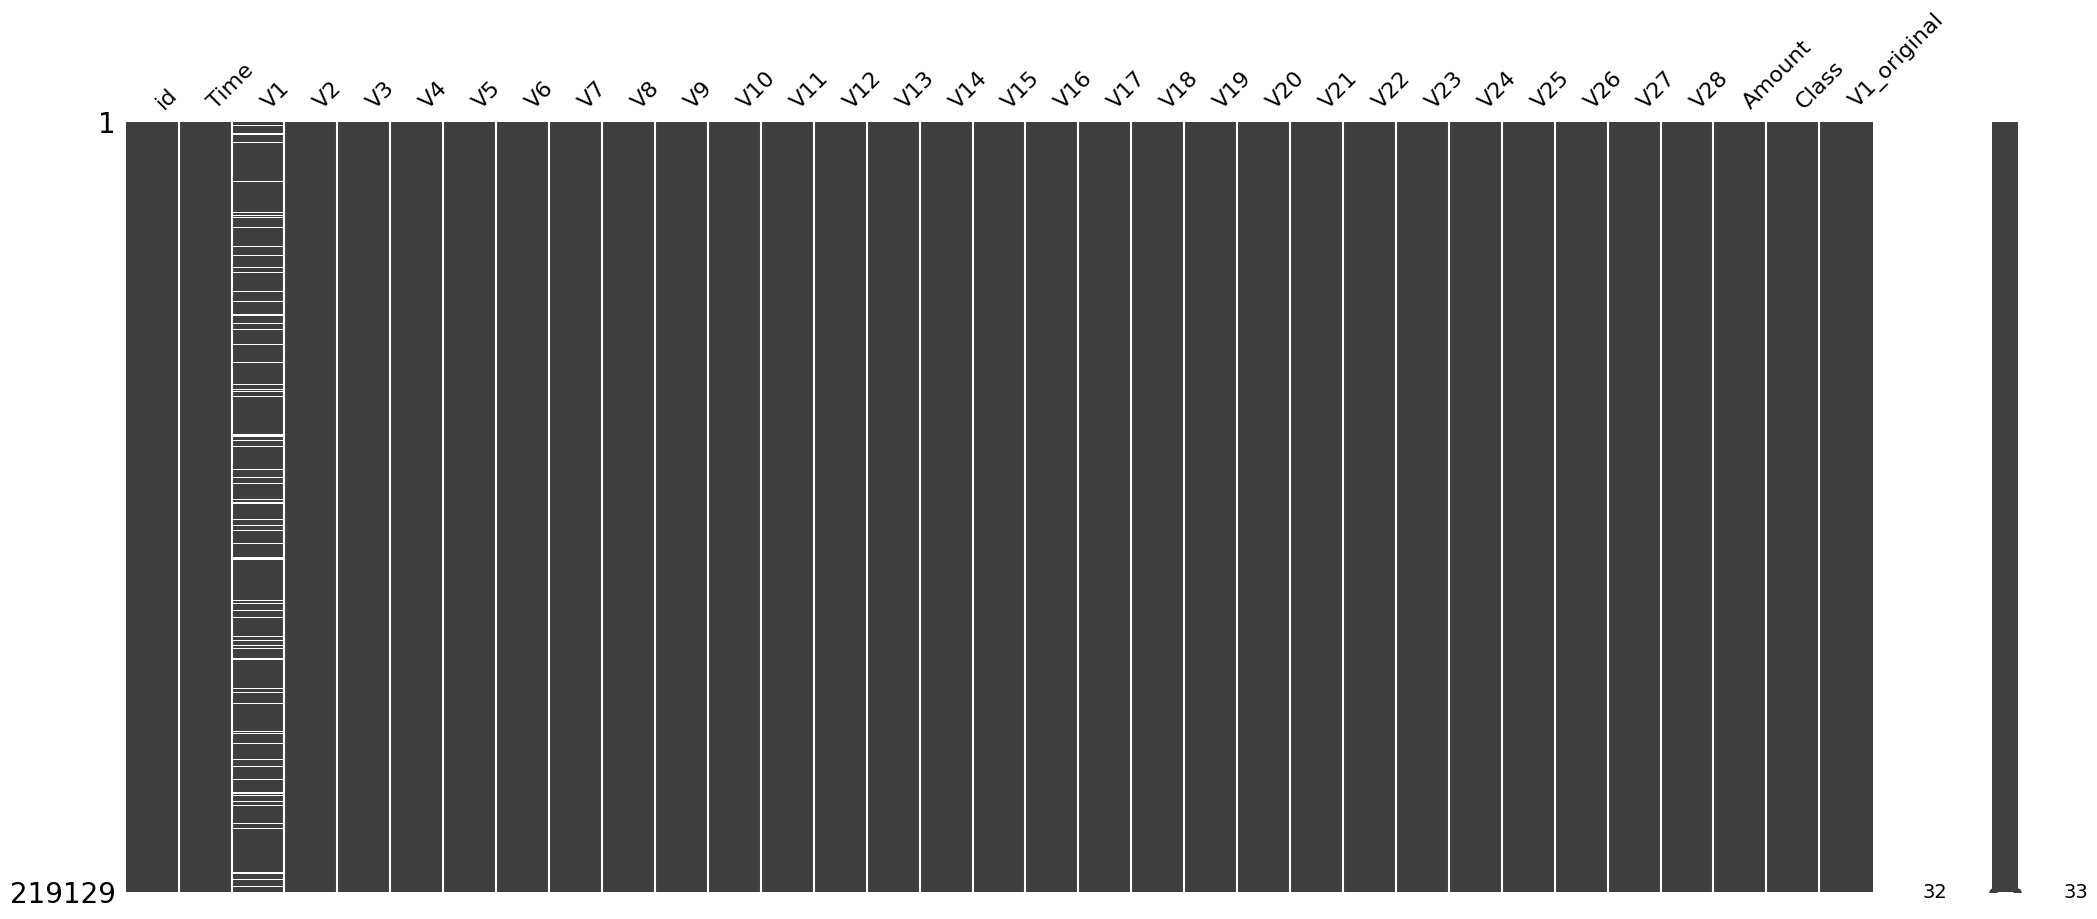

In [141]:
#Visualize the missing data
msno.matrix(df)

## 1. Mean, Median, and Mode Imputation

Mean imputation

In [181]:
df_mean = df.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean['V1'] = mean_imputer.fit_transform(df_mean['V1'].values.reshape(-1,1))

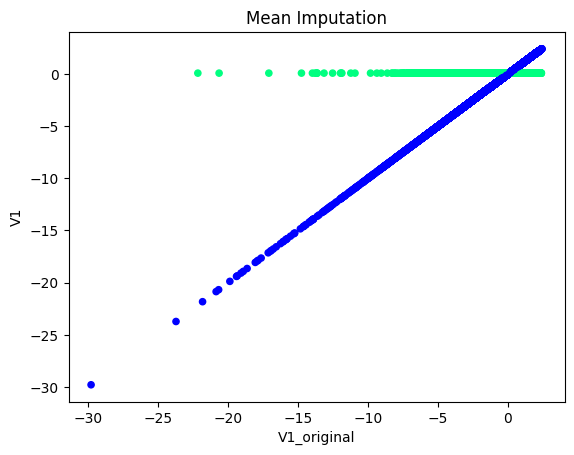

In [143]:
# Mean imputation Scatter plot: comparing transformed data and original data
# Green points are transformed data and blue points are original data
fig = plt.Figure()
null_values = df['V1'].isnull()
fig = df_mean.plot(x="V1_original", y='V1', kind='scatter', c=null_values, cmap='winter', title='Mean Imputation', colorbar=False)

Median imputation

In [144]:
df_median = df.copy()
median_imputer = SimpleImputer(strategy='median')
df_median['V1'] = median_imputer.fit_transform(df_median['V1'].values.reshape(-1,1))

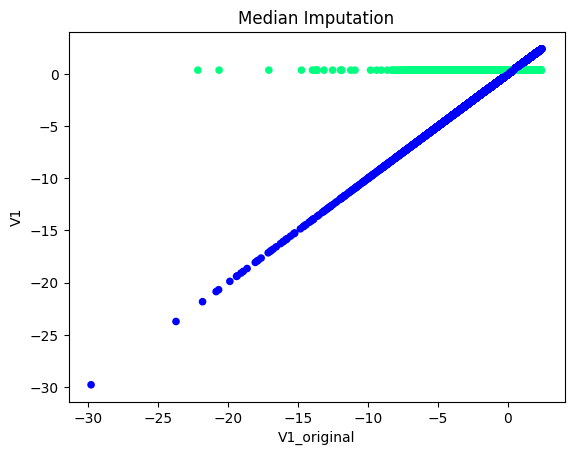

In [145]:
# Median imputation Scatter plot: comparing transformed data and original data
# Green points are transformed data and blue points are original data
fig = plt.Figure()
null_values = df['V1'].isnull()
fig = df_median.plot(x="V1_original", y='V1', kind='scatter', c=null_values, cmap='winter', title='Median Imputation', colorbar=False)

Mode imputation

In [146]:
df_mode = df.copy()
mode_imputer = SimpleImputer(strategy='most_frequent')
df_mode['V1'] = mode_imputer.fit_transform(df_mode['V1'].values.reshape(-1,1))

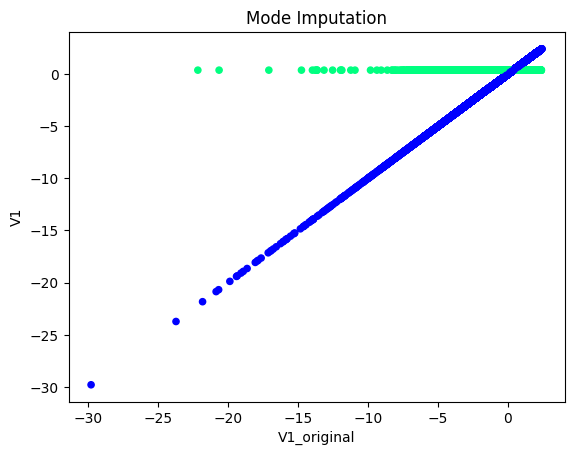

In [147]:
# Mode imputation scatter plot: comparing transformed data and original data
# Green points are transformed data and blue points are original data
fig = plt.Figure()
null_values = df['V1'].isnull()
fig = df_median.plot(x="V1_original", y='V1', kind='scatter', c=null_values, cmap='winter', title='Mode Imputation', colorbar=False)

## 2. K-Nearest Neighbours (KNN) Imputation

In [148]:
# K-Nearest Neighbour (KNN) Imputation
# Imputing with KNNImputer

#Define a subset of the dataset
df_knn = df.filter(['Time','V1','V2','V3'], axis=1).copy()

In [149]:
# Define scaler to set values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

In [150]:
# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

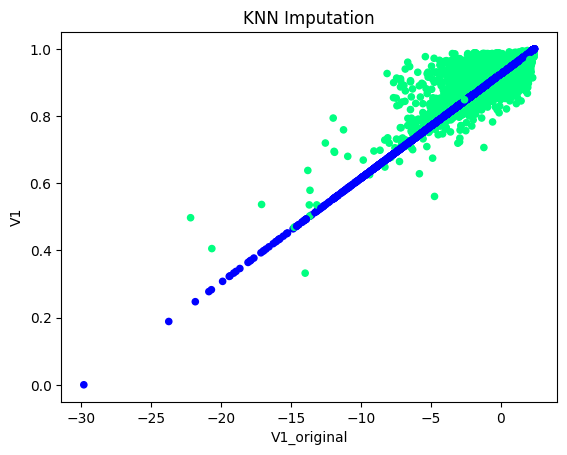

In [ ]:
# Add 'V1_original' column to df_knn_imputed DataFrame
df_knn_imputed['V1_original'] = df['V1_original']
# KNN imputation scatter plot: comparing imputed data and original data
# Green points are imputed data and blue points are original data
fig = plt.Figure()
null_values = df['V1'].isnull() 
fig = df_knn_imputed.plot(x='V1_original', y='V1', kind='scatter', c=null_values, cmap='winter', title='KNN Imputation', colorbar=False)


## 3.Multivariate Imputation by Chained Equation (MICE)

In [ ]:
# Imputing with MICE
df_mice = df.filter(['Time','V1','V2','V3'], axis=1).copy()

In [ ]:
# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

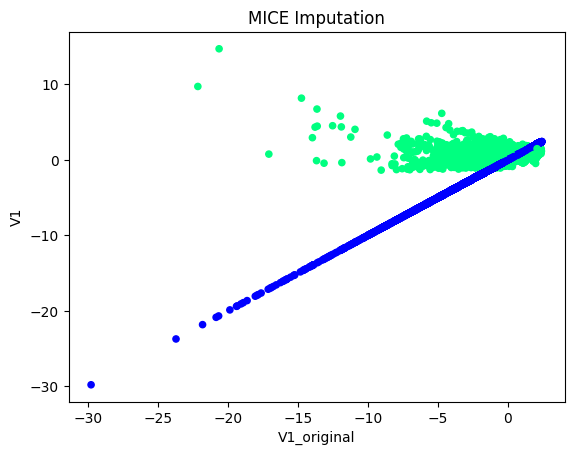

In [154]:
# Add 'V1_original' column to df_knn_imputed DataFrame
df_mice_imputed['V1_original'] = df['V1_original']
# MICE imputation scatter plot: comparing imputed data and original data
# Green points are imputed data and blue points are original data
fig = plt.Figure()
null_values = df['V1'].isnull() 
fig = df_mice_imputed.plot(x='V1_original', y='V1', kind='scatter', c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

In conclusion, KNN imputation demonstrates the best performance among the compared methods, providing imputed data that is more closely aligned with the original dataset. While Mean, Median, and Mode Imputations offer a straightforward approach, they can introduce biases, particularly in cases of skewed distributions. MICE imputation performs better than these basic techniques but falls short of KNN imputation. Therefore, KNN imputation is recommended for optimal performance when dealing with missing data.

# Model Training & Selection
In this section we will develop models to determine how likely a transaction is fraudulent; we do this by first developing a set of classification models and measure the performance of each of those, before going on to improve them through means such as hyperparameter-tuning.

Our target column (`Class`) has a significant imbalance with fraudulent (`1`) cases in the minority. With little data to train our model on, it will be difficult to predict which transactions are fraudulent successfully. We use F1 scores (harmonic mean of precision and recall) and ROC curves as our main measures of model performance.

During the data exploration and cleaning stage, outliers were removed from the data. This cleaned dataset will be imported for use in this section.

In [155]:
train_csv = pd.read_csv('data/train_no_outliers.csv')
test_csv = pd.read_csv('data/test.csv')

display(train_csv.head()) # check the data has imported correctly

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


Check for duplicated rows/remove if necessary.

In [156]:
print(f"# of duplicated rows: ", train_csv.duplicated().sum())

# of duplicated rows:  0


 Even though there are no duplicates present in our training set, it is good practice to define a transformer for this regardless, as this may not be the same case for all the data we use.

In [158]:
def drop_duplicate_rows(df):
    return df.drop_duplicates()

drop_dupe_transformer = FunctionTransformer(drop_duplicate_rows)

Train-test split. Not the use of stratification in order to keep class distributions similar across the test/training sets

In [159]:
train_set, test_set = train_test_split(train_csv, test_size=0.20, random_state=0, stratify=train_csv['Class'])
print(train_set.shape)
print(test_set.shape)

(172573, 32)
(43144, 32)


A quick check to see whether the distribution of classes is similar after the split.

In [160]:
class_dists = pd.concat([train_csv['Class'].value_counts(normalize=True).rename('before'), train_set['Class'].value_counts(
    normalize=True).rename('after')], keys=['before', 'after'], axis=0).reset_index()
class_dists = class_dists.set_axis(['stage', 'class', 'count'], axis=1)
class_dists

,stage,class,count
0,before,0,0.997826
1,before,1,0.002174
2,after,0,0.997827
3,after,1,0.002173


We simplify the time column to its hour (0--23) in order to reduce variance within the column for better training. It is also reasonable to investigate whether the time of day a transaction is made at has any effect on the probability that it is fraudulent.

In [161]:
def split_time_col(df):
    """ Simplifies 'Time' to 'hour' column """
    new_df = df.copy()
    new_df['hour'] = df.loc[:, 'Time'] % 24
    return new_df.drop(columns=['Time'])

time_col_transformer = FunctionTransformer(split_time_col)
train_set = time_col_transformer.transform(train_set)
display(train_set)

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
211202,214537,1.967284,-0.015726,-1.582950,0.161858,0.252038,-0.539886,0.058322,-0.141517,0.642879,...,-0.523948,0.149571,-0.442360,-0.038249,-0.126037,-0.007940,-0.038675,34.66,0,13.0
148523,150838,1.316845,0.249827,-0.168824,0.858753,0.322260,-0.000233,0.067697,-0.051719,0.164876,...,-0.204940,-0.230447,-1.038484,0.780869,-0.302348,0.021953,0.012705,7.49,0,22.0
137659,139809,-0.414256,0.638374,0.054236,-1.516442,2.595727,3.382359,-0.098696,0.835162,-0.374748,...,-0.603547,0.027699,0.953469,-0.489899,-0.104417,0.049678,0.036820,1.98,0,12.0
150334,152674,0.938372,-0.424629,0.483914,0.816642,-0.515131,-0.032035,-0.099160,0.113379,0.185604,...,-0.170584,-0.028704,0.165798,0.203964,0.282749,-0.051349,0.018404,129.99,0,16.0
212950,216307,-1.415824,1.333776,-1.387735,-0.070067,0.031350,-1.478545,0.482639,0.087244,0.562222,...,0.849980,0.060189,-0.238899,-0.335727,-0.156598,-0.826205,0.058150,35.67,0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138792,140958,1.099536,-0.124527,-0.051765,0.641479,0.716210,2.322614,-0.499295,0.686778,0.581410,...,0.102908,-0.045149,-1.918663,0.433341,0.444950,0.072405,-0.019237,5.89,0,18.0
25734,26028,1.217984,-0.336905,0.423181,-0.060059,-0.373317,0.039528,-0.365818,0.047970,0.651407,...,-0.354830,-0.123524,-0.255871,0.302696,0.973452,-0.067754,-0.004588,30.00,0,17.0
837,845,1.236849,0.263715,0.126566,0.906384,-0.466858,-1.448835,0.352658,-0.295484,-0.047068,...,-0.140750,-0.039338,0.927787,0.496795,0.365708,-0.052548,0.009783,19.99,0,17.0
92750,94200,-1.276725,1.242947,1.014765,-0.890977,-0.358098,-0.715167,0.252944,0.664121,-0.611898,...,-0.717153,0.068478,0.057718,-0.086339,0.723488,0.004919,0.072925,19.99,0,16.0


The `id` column is not needed as it is unique for each entry.

In [162]:
def drop_id(df):
    return df.drop(columns='id')

drop_id_transformer= FunctionTransformer(drop_id)
train_set = drop_id_transformer.transform(train_set)
display(train_set)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
211202,1.967284,-0.015726,-1.582950,0.161858,0.252038,-0.539886,0.058322,-0.141517,0.642879,-0.640922,...,-0.523948,0.149571,-0.442360,-0.038249,-0.126037,-0.007940,-0.038675,34.66,0,13.0
148523,1.316845,0.249827,-0.168824,0.858753,0.322260,-0.000233,0.067697,-0.051719,0.164876,0.046979,...,-0.204940,-0.230447,-1.038484,0.780869,-0.302348,0.021953,0.012705,7.49,0,22.0
137659,-0.414256,0.638374,0.054236,-1.516442,2.595727,3.382359,-0.098696,0.835162,-0.374748,-0.823898,...,-0.603547,0.027699,0.953469,-0.489899,-0.104417,0.049678,0.036820,1.98,0,12.0
150334,0.938372,-0.424629,0.483914,0.816642,-0.515131,-0.032035,-0.099160,0.113379,0.185604,-0.146416,...,-0.170584,-0.028704,0.165798,0.203964,0.282749,-0.051349,0.018404,129.99,0,16.0
212950,-1.415824,1.333776,-1.387735,-0.070067,0.031350,-1.478545,0.482639,0.087244,0.562222,-0.279898,...,0.849980,0.060189,-0.238899,-0.335727,-0.156598,-0.826205,0.058150,35.67,0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138792,1.099536,-0.124527,-0.051765,0.641479,0.716210,2.322614,-0.499295,0.686778,0.581410,-0.250934,...,0.102908,-0.045149,-1.918663,0.433341,0.444950,0.072405,-0.019237,5.89,0,18.0
25734,1.217984,-0.336905,0.423181,-0.060059,-0.373317,0.039528,-0.365818,0.047970,0.651407,-0.274900,...,-0.354830,-0.123524,-0.255871,0.302696,0.973452,-0.067754,-0.004588,30.00,0,17.0
837,1.236849,0.263715,0.126566,0.906384,-0.466858,-1.448835,0.352658,-0.295484,-0.047068,-0.000340,...,-0.140750,-0.039338,0.927787,0.496795,0.365708,-0.052548,0.009783,19.99,0,17.0
92750,-1.276725,1.242947,1.014765,-0.890977,-0.358098,-0.715167,0.252944,0.664121,-0.611898,-0.583627,...,-0.717153,0.068478,0.057718,-0.086339,0.723488,0.004919,0.072925,19.99,0,16.0


Finally, we standardise the `hour` column we created, as well as the `Amount` column which appears to not have been standardised. This makes for better input to train our models with. There is no need to train the remaining columns, as they have already been standardised using a PCA approach.

In [163]:
scaler = StandardScaler()
scaler_transformer = ColumnTransformer([('standard-scaler', StandardScaler(), ['hour', 'Amount'])], verbose_feature_names_out=False, remainder='passthrough')
scaler_transformer.set_output(transform='pandas')
train_set = scaler_transformer.fit_transform(train_set)
train_set

,hour,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
211202,0.198769,-0.232967,1.967284,-0.015726,-1.582950,0.161858,0.252038,-0.539886,0.058322,-0.141517,...,-0.012924,-0.254968,-0.523948,0.149571,-0.442360,-0.038249,-0.126037,-0.007940,-0.038675,0
148523,1.491214,-0.471707,1.316845,0.249827,-0.168824,0.858753,0.322260,-0.000233,0.067697,-0.051719,...,-0.133358,-0.084529,-0.204940,-0.230447,-1.038484,0.780869,-0.302348,0.021953,0.012705,0
137659,0.055164,-0.520123,-0.414256,0.638374,0.054236,-1.516442,2.595727,3.382359,-0.098696,0.835162,...,0.008836,-0.102300,-0.603547,0.027699,0.953469,-0.489899,-0.104417,0.049678,0.036820,0
150334,0.629584,0.604688,0.938372,-0.424629,0.483914,0.816642,-0.515131,-0.032035,-0.099160,0.113379,...,0.066245,-0.025273,-0.170584,-0.028704,0.165798,0.203964,0.282749,-0.051349,0.018404,0
212950,0.342374,-0.224092,-1.415824,1.333776,-1.387735,-0.070067,0.031350,-1.478545,0.482639,0.087244,...,-0.316814,0.315866,0.849980,0.060189,-0.238899,-0.335727,-0.156598,-0.826205,0.058150,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138792,0.916794,-0.485767,1.099536,-0.124527,-0.051765,0.641479,0.716210,2.322614,-0.499295,0.686778,...,-0.274518,-0.061327,0.102908,-0.045149,-1.918663,0.433341,0.444950,0.072405,-0.019237,0
25734,0.773189,-0.273914,1.217984,-0.336905,0.423181,-0.060059,-0.373317,0.039528,-0.365818,0.047970,...,0.082865,-0.198606,-0.354830,-0.123524,-0.255871,0.302696,0.973452,-0.067754,-0.004588,0
837,0.773189,-0.361871,1.236849,0.263715,0.126566,0.906384,-0.466858,-1.448835,0.352658,-0.295484,...,-0.155579,-0.025348,-0.140750,-0.039338,0.927787,0.496795,0.365708,-0.052548,0.009783,0
92750,0.629584,-0.361871,-1.276725,1.242947,1.014765,-0.890977,-0.358098,-0.715167,0.252944,0.664121,...,-0.122512,-0.174909,-0.717153,0.068478,0.057718,-0.086339,0.723488,0.004919,0.072925,0


Recall the imbalance between fraudulent and non-fraudulent cases in our data---as mentioned previously, it is likely that a lack of data for fraudulent transactions will affect our model performance. We can test this by first training a simple linear model with our data.

In [164]:
def get_classification_report(model, data_x, data_y):
    predictions = model.predict(data_x)
    return classification_report(data_y, predictions)

sgd = SGDClassifier(random_state=0).fit(train_set.drop(columns='Class'), train_set['Class'].copy())

print(get_classification_report(sgd, train_set.drop(columns='Class'), train_set['Class'].copy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    172198
           1       0.50      0.13      0.21       375

    accuracy                           1.00    172573
   macro avg       0.75      0.57      0.60    172573
weighted avg       1.00      1.00      1.00    172573



Looking at the confusion matrix:

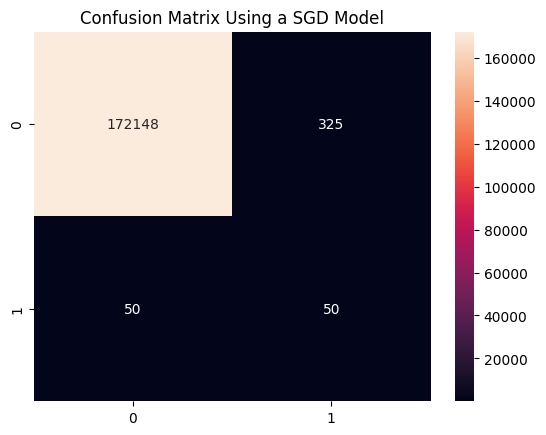

In [166]:
def plot_confusion_matrix(y_true, y_predicted, title):
    mtrx = confusion_matrix(y_true, y_predicted)
    sns.heatmap(mtrx, annot=True, fmt='d')
    plt.title(title)
    plt.show()

plot_confusion_matrix(train_set['Class'], sgd.predict(train_set.drop(columns='Class')), 'Confusion Matrix Using a SGD Model')

172,148 transactions predicted as "not fraud" and actually "not fraud" - **True Negative**\
325 transactions predicted as "fraud" and actually "fraud" - **True Positive**\
50 transactions predicted as "fraud" but not actually "fraud" - **False Positive**\
50 transactions predicted as "not fraud" but actually "fraud" - **False Negative**

These results show that our model is not able to accurately classify fraudulent transactions (`0`); the high accuracy for non-fraudulent cases is likely not due to the model's capabilities, but a consequence of the high proportion of non-fraudulent transactions in the dataset.

What can we do? There are two main methodologies to deal with this problem (Imbalanced Classes):

- **Oversampling**: the aim here is up-sampled minority class. Some pros using this methodology is that both classes will be balanced in the data-set but also arises a few drawbacks for example as the data increase its size any training process will require more computing resosurces.

- **Undersampling**: the aim here is down-sample the majority class to converge the same length as the minority class. The same pros as the first approach (oversampling), but here you will lose information on the majority class (delete randomnly instances of this class to converge to a balance data ser).

During this work we will use oversampling approach using SMOTE (Synthetic Minority Oversampling Technique)

In [167]:
smote = SMOTE(random_state=0)
train_set_imbalanced = train_set.copy()
train_set, train_labels = smote.fit_resample(train_set.drop(columns=['Class']), train_set['Class'])

Now if we look at the class distribution:

In [170]:
print(train_labels.value_counts(normalize=True))

Class
0    0.5
1    0.5
Name: proportion, dtype: float64


Looking at model performance now:

In [171]:
sgd = SGDClassifier(random_state=0).fit(train_set, train_labels)

print(get_classification_report(sgd, train_set, train_labels))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75    172198
           1       0.77      0.68      0.72    172198

    accuracy                           0.74    344396
   macro avg       0.74      0.74      0.74    344396
weighted avg       0.74      0.74      0.74    344396



And the confusion matrix

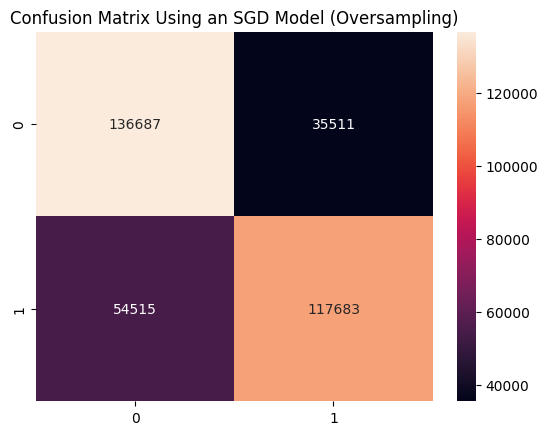

In [172]:
plot_confusion_matrix(train_labels, sgd.predict(train_set), 'Confusion Matrix Using an SGD Model (Oversampling)')

Our errors are now more balanced between classes, though there is still some work to be done to improve overall performance.

If we look at the correlation matrices before and after oversampling:

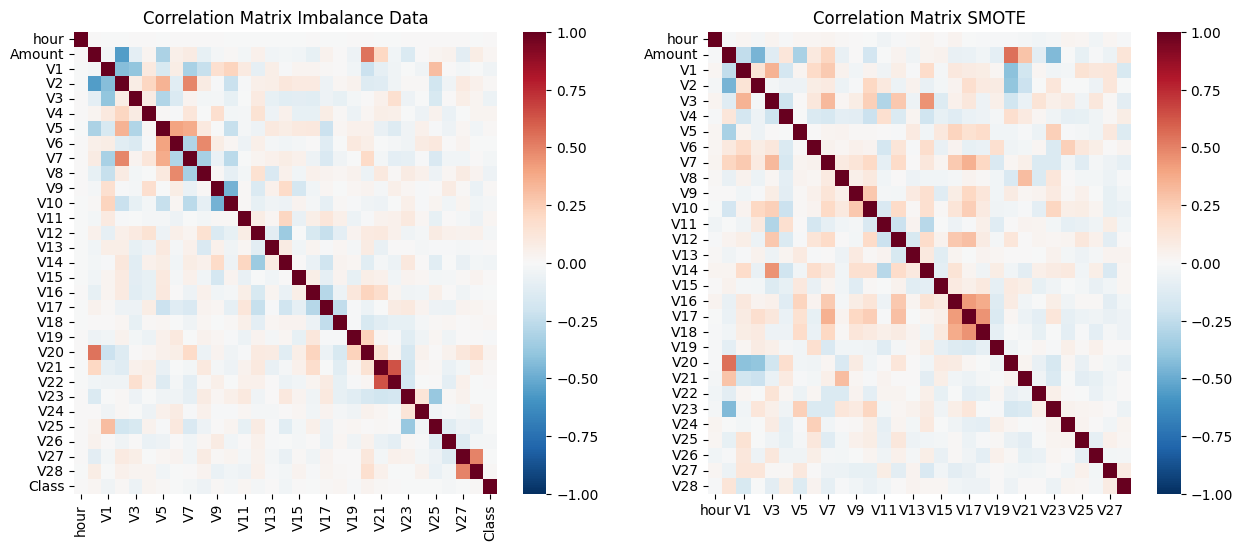

In [173]:
fig, ax =plt.subplots(1,2, figsize=(15, 6))
corr_matrix_train = train_set_imbalanced.corr()
corr_matrix_OS = train_set.corr()
sns.heatmap(corr_matrix_train, annot=False, cmap='RdBu_r', vmin=-1, vmax=1, ax=ax[0])
sns.heatmap(corr_matrix_OS, annot=False, cmap='RdBu_r', vmin=-1, vmax=1, ax=ax[1])
ax[0].title.set_text('Correlation Matrix Imbalance Data')
ax[1].title.set_text('Correlation Matrix SMOTE')
fig.show()

Comparing the last row, which shows correlations with `Class`, we can see that using a balance data (SMOTE) results in a higher correlation with other features, meaning that oversampling should help us obtain better results from our models.

Finally we combine our transformations into a pipeline, and re-split our dataset in order to fit the transformer to our training data.

In [174]:
pipeline = make_pipeline(time_col_transformer, drop_id_transformer, scaler_transformer, verbose=True)
pipeline.set_output(transform='pandas')

train_set, test_set = train_test_split(train_csv, test_size=0.20, random_state=0, stratify=train_csv['Class'])
train_set = pipeline.fit_transform(train_set)
train_set, train_labels = smote.fit_resample(train_set.drop(columns='Class'), train_set['Class'].copy())

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


[Pipeline]  (step 1 of 3) Processing functiontransformer-1, total=   0.0s
[Pipeline]  (step 2 of 3) Processing functiontransformer-2, total=   0.0s
[Pipeline] . (step 3 of 3) Processing columntransformer, total=   0.0s


We define a function to measure the performance scores of a number of models:

In [175]:
def get_scores(train_x, train_y, models, k_fold=False):
    """
    Runs a series of given classifiers and returns a dataframe detailing their accuracy, precision, recall, and f1 scores
    :param train_x: training features
    :param train_y: training labels
    :param models: list of models
    :param k_fold: whether to use cross-validation; defaults to false
    :return:
    """

    results = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    if k_fold:
        results['k'] = []

    for model in models:
        # fit model to train data
        model.fit(train_x, train_y)

        if k_fold:
            cv_scores = cross_validate(model, train_x, train_y,
                                       scoring=['accuracy', 'precision', 'recall', 'f1'])

            # get scores
            for k in range(5):
                results['model'].append(type(model).__name__)
                results['k'].append(k)
                results['accuracy'].append(cv_scores['test_accuracy'][k])
                results['precision'].append(cv_scores['test_precision'][k])
                results['recall'].append(cv_scores['test_recall'][k])
                results['f1'].append(cv_scores['test_f1'][k])

        else:
            predictions = model.predict(train_x)
            # get scores
            results['model'].append(type(model).__name__)
            results['accuracy'].append(accuracy_score(predictions, train_y))
            results['precision'].append(precision_score(predictions, train_y))
            results['recall'].append(recall_score(predictions, train_y))
            results['f1'].append(f1_score(predictions, train_y))

    # convert to df and return
    return pd.DataFrame(results)

First, we set no (optional) hyperparameters to measure a baseline performance.

In [176]:
models = [SGDClassifier(random_state=0), LogisticRegression(random_state=0), RandomForestClassifier(random_state=0), DecisionTreeClassifier(random_state=0), HistGradientBoostingClassifier(random_state=0)]

display(get_scores(train_set, train_labels, models))

,model,accuracy,precision,recall,f1
0,SGDClassifier,0.738597,0.683417,0.768196,0.723331
1,LogisticRegression,0.742300,0.703278,0.762810,0.731835
2,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
3,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
4,HistGradientBoostingClassifier,0.985401,0.984059,0.986706,0.985381


Note that some of these models appear to have a perfect accuracy (along with other scores). This is too good to be true---what is likely the case is that our models have been overfit. We can also look at the classification report for more detailed scores repective to class.

In [178]:
reports = {}

for model in models:
    reports[type(model).__name__] = get_classification_report(model, train_set, train_labels)

for key in reports.keys():
    print(f'CLASSIFICATION REPORT FOR {key}')
    print(reports[key])

CLASSIFICATION REPORT FOR SGDClassifier
              precision    recall  f1-score   support

           0       0.71      0.79      0.75    172198
           1       0.77      0.68      0.72    172198

    accuracy                           0.74    344396
   macro avg       0.74      0.74      0.74    344396
weighted avg       0.74      0.74      0.74    344396

CLASSIFICATION REPORT FOR LogisticRegression
              precision    recall  f1-score   support

           0       0.72      0.78      0.75    172198
           1       0.76      0.70      0.73    172198

    accuracy                           0.74    344396
   macro avg       0.74      0.74      0.74    344396
weighted avg       0.74      0.74      0.74    344396

CLASSIFICATION REPORT FOR RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    172198
           1       1.00      1.00      1.00    172198

    accuracy                           1.00    3

Let's consider a classifier that simply marks all transactions as 'non-fraud' and see the accuracy of this:

In [180]:
accuracy_baseline = (train_set.shape[0]-train_labels.sum())/train_set.shape[0]
print("Baseline Accuracy on Train: {0:.2%}".format(accuracy_baseline))

Baseline Accuracy on Train: 50.00%


Accuracy is similar across classes, but our previous point still stands. The models have overfit. To confirm this, we can use K-Cross-Fold-Validation.

In [179]:
kf_scores = get_scores(train_set, train_labels, models, k_fold=True)
kf_scores['mean'] = kf_scores.mean(numeric_only=True, axis=1)
display(kf_scores)

,model,accuracy,precision,recall,f1,k,mean
0,SGDClassifier,0.739649,0.738162,0.742770,0.740459,0,0.592208
1,SGDClassifier,0.740458,0.791872,0.652371,0.715384,1,0.780017
2,SGDClassifier,0.740313,0.793371,0.649874,0.714489,2,0.979609
3,SGDClassifier,0.744654,0.775180,0.689199,0.729665,3,1.187739
4,SGDClassifier,0.741445,0.779672,0.673113,0.722485,4,1.383343
5,LogisticRegression,0.742843,0.763376,0.703862,0.732412,0,0.588498
6,LogisticRegression,0.744276,0.762882,0.708877,0.734889,1,0.790185
7,LogisticRegression,0.740821,0.761024,0.702111,0.730381,2,0.986867
8,LogisticRegression,0.742882,0.765724,0.699913,0.731341,3,1.187972
9,LogisticRegression,0.740879,0.761028,0.702294,0.730482,4,1.386937


In [184]:
display(kf_scores.drop(columns='k').groupby('model').mean())

,accuracy,precision,recall,f1,mean
model,,,,,
DecisionTreeClassifier,0.987837,0.981107,0.994832,0.987921,1.190339
HistGradientBoostingClassifier,0.982773,0.985165,0.980313,0.982730,1.186196
LogisticRegression,0.742340,0.762807,0.703411,0.731901,0.988092
RandomForestClassifier,0.999396,0.998869,0.999925,0.999396,1.199517
SGDClassifier,0.741304,0.775651,0.681465,0.724496,0.984583


The SGD and LR classifiers seem to have more realistic predictions, however we cannot take these results this easily. We will now go on to tune these models in order to assess which is the best performing.

## Stochastic Gradient Descent

In [ ]:
sgd_grid = {
    'learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.25, 0.5, 0.75],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'loss': ['hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
}

sgd_searchcv = GridSearchCV(estimator=SGDClassifier(random_state=0), param_grid=sgd_grid, verbose=5, cv=3, n_jobs=-1)
sgd_searchcv.fit(train_set, train_labels)
print(sgd_searchcv.best_estimator_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
SGDClassifier(eta0=0.25, learning_rate='invscaling', penalty='elasticnet',
              random_state=0)


If we test this tuned model against our training data:

              precision    recall  f1-score   support

           0       0.72      0.80      0.76    172198
           1       0.77      0.69      0.73    172198

    accuracy                           0.74    344396
   macro avg       0.75      0.74      0.74    344396
weighted avg       0.75      0.74      0.74    344396



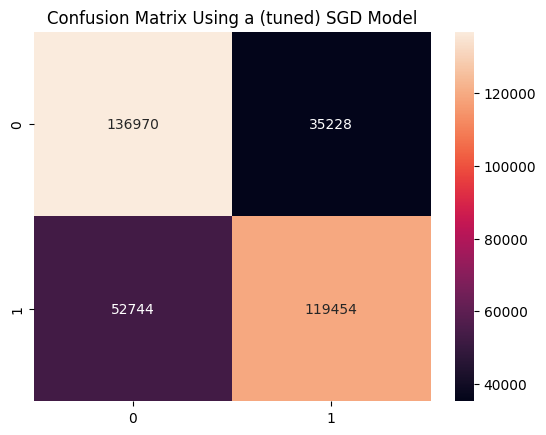

In [202]:
print(get_classification_report(sgd_searchcv.best_estimator_, train_set, train_labels))
plot_confusion_matrix(sgd_searchcv.predict(train_set), train_labels, 'Confusion Matrix Using a (tuned) SGD Model')

We appear to have a decently-spread performance. We now test this tuned model against the portion of the training set we reserved as a test set for a penultimate measure of its performance. As we are not oversampling this data, we should normalise the confusion matrix in order to get results more representative of our model's performance.

In [199]:
test_set = pipeline.transform(test_set)
test_labels = test_set['Class'].copy()
test_set = test_set.drop(columns='Class')

              precision    recall  f1-score   support

           0       1.00      0.79      0.88     43050
           1       0.01      0.69      0.01        94

    accuracy                           0.79     43144
   macro avg       0.50      0.74      0.45     43144
weighted avg       1.00      0.79      0.88     43144



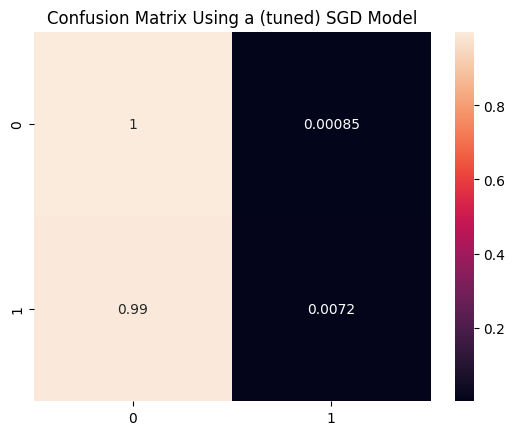

In [214]:
def plot_confusion_matrix_normalised(y_true, y_predicted, title):
    cm = confusion_matrix(y_true, y_predicted)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True)
    plt.title(title)
    plt.show()

print(get_classification_report(sgd_searchcv.best_estimator_, test_set, test_labels))
plot_confusion_matrix_normalised(sgd_searchcv.predict(test_set), test_labels, 'Confusion Matrix Using a (tuned) SGD Model')

This model still has a poor performance in identifying fraud cases and is not an ideal candidate for our final model.

## Logistic Regression

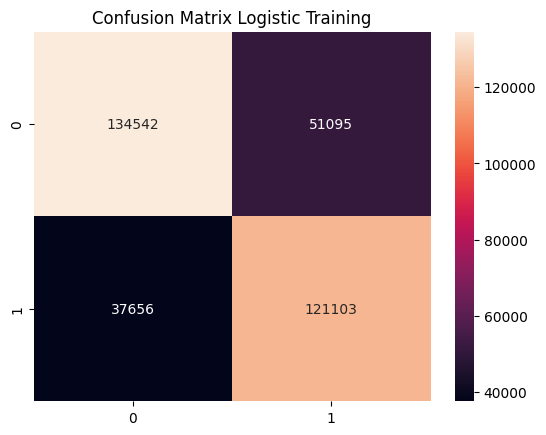

In [215]:
LRClassifier = LogisticRegression(random_state=0)
LRClassifier.fit(train_set, train_labels)
predict_LR_train_OS = LRClassifier.predict(train_set)

plot_confusion_matrix(train_labels, predict_LR_train_OS, 'Confusion Matrix Logistic Training')

As a first conclusion, False Positives and False Negative are more balanced here than in the previous model (SGD)

134,542 transactions predicted as "not fraud" and actually "not fraud" - **True Negative**\
51,095 transactions predicted as "fraud" and actually "fraud" - **True Positive**\
37,656 transactions predicted as "fraud" but not actually "fraud" - **False Positive**\
121,103 transactions predicted as "not fraud" but actually "fraud" - **False Negative**

We can tune this model to see if results improve.

In [209]:
lr_grid = {
    'penalty': [None, 'l2'],
    'multi_class': ['ovr'],
    'solver': ['lbfgs', 'newton-cholesky'],
    'C': [0.001, 0.5, 1, 3],
}

lr_searchcv = GridSearchCV(estimator=LogisticRegression(random_state=0), param_grid=lr_grid, verbose=5, cv=3, n_jobs=-1)
lr_searchcv.fit(train_set, train_labels)
print(sgd_searchcv.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

SGDClassifier(eta0=0.25, learning_rate='invscaling', penalty='elasticnet',
              random_state=0)


              precision    recall  f1-score   support

           0       0.72      0.78      0.75    172198
           1       0.76      0.70      0.73    172198

    accuracy                           0.74    344396
   macro avg       0.74      0.74      0.74    344396
weighted avg       0.74      0.74      0.74    344396



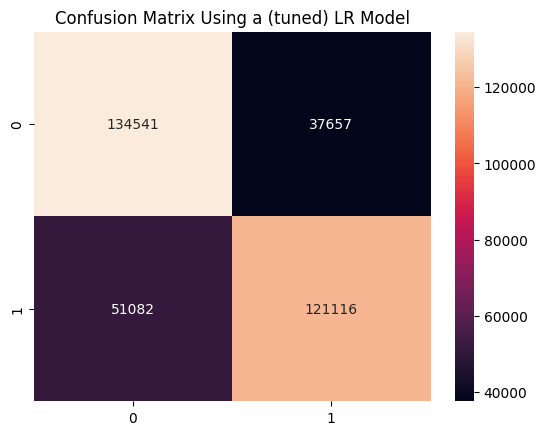

In [217]:
print(get_classification_report(lr_searchcv.best_estimator_, train_set, train_labels))
plot_confusion_matrix(lr_searchcv.predict(train_set), train_labels, 'Confusion Matrix Using a (tuned) LR Model')

And on our validation set:

              precision    recall  f1-score   support

           0       1.00      0.78      0.87     43050
           1       0.01      0.68      0.01        94

    accuracy                           0.78     43144
   macro avg       0.50      0.73      0.44     43144
weighted avg       1.00      0.78      0.87     43144



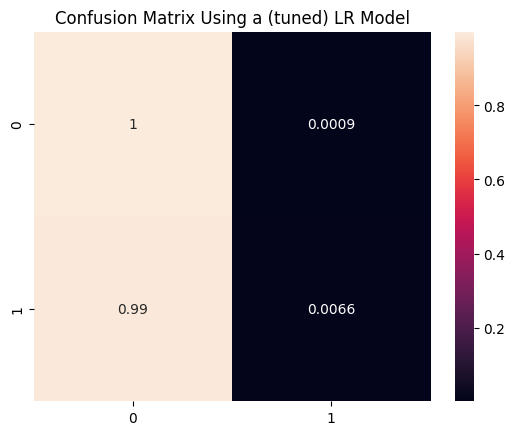

In [218]:
print(get_classification_report(lr_searchcv.best_estimator_, test_set, test_labels))
plot_confusion_matrix_normalised(lr_searchcv.predict(test_set), test_labels, 'Confusion Matrix Using a (tuned) LR Model')

Again, the model is not good at identifying fraud cases.

From validation set I will extract first 90 fraud and 90 non fraud transactions

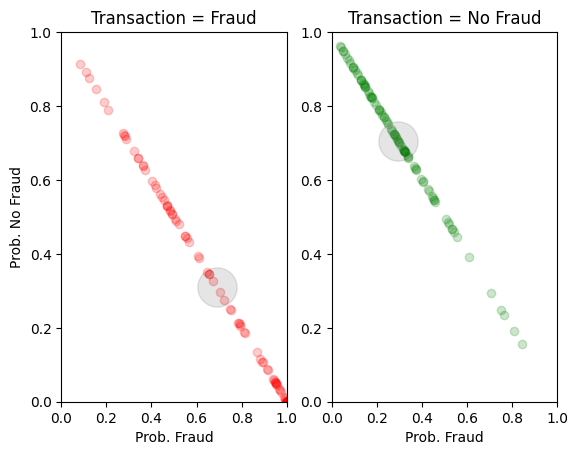

In [239]:
No_Fraud_val = test_labels[test_labels == 0].iloc[:90]
Fraud_val = test_labels[test_labels == 1].iloc[:90]

X_Fraud_val = test_set.loc[test_labels[test_labels == 1].iloc[:90].index]
X_No_Fraud_val = test_set.loc[test_labels[test_labels == 0].iloc[:90].index]

Probs_Fraud = lr_searchcv.predict_proba(X_Fraud_val)
Probs_NoFraud = lr_searchcv.predict_proba(X_No_Fraud_val)

Probs = {}

Probs["F_noFraud"] = Probs_Fraud[:,0]
Probs["F_Fraud"] = Probs_Fraud[:,1]
Probs["NF_noFraud"] = Probs_NoFraud[:,0]
Probs["NF_Fraud"] = Probs_NoFraud[:,1]

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(Probs["F_Fraud"], Probs["F_noFraud"], c="red", alpha=0.2)
plt.scatter(np.mean(Probs["F_Fraud"]), np.mean(Probs["F_noFraud"]), c="black", alpha=0.1, s=800)
plt.title("Transaction = Fraud")
plt.xlabel('Prob. Fraud')
plt.ylim(0,1)
plt.xlim(0,1)
plt.ylabel('Prob. No Fraud')


plt.subplot(1, 2, 2) # index 2
plt.scatter(Probs["NF_Fraud"], Probs["NF_noFraud"], c="green", alpha=0.2)
plt.scatter(np.mean(Probs["NF_Fraud"]), np.mean(Probs["NF_noFraud"]), c="black", alpha=0.1, s=800)
plt.title("Transaction = No Fraud")
plt.xlabel('Prob. Fraud')
plt.ylim(0,1)
plt.xlim(0,1)
plt.ylabel('')


plt.show()

Its evident looking predicted probabilities that model on average (big gray circle above) perform well by predict type of transaction

## Random Forest
To not overfit we will restrict the following hyperparameters:
- max_features: 30% of total features (9 features)
- max_depth: 10
- min_samples_leaf: 5

In [241]:
rf_model = RandomForestClassifier(random_state=0, max_features=9, max_depth=5, min_samples_leaf=5)
#counter time
start = time.perf_counter()
rf_model.fit(train_set, train_labels)
end = time.perf_counter()

predict_RF_train = rf_model.predict(train_set)

print("Random Forest Classifier spent {0:.2f} minutes to fit the model".format((end-start)/60))

Random Forest Classifier spent 1.70 minutes to fit the model


Wow, this model is intensive on time! We have this on mind when set main hyperparameters for tuning each of those later

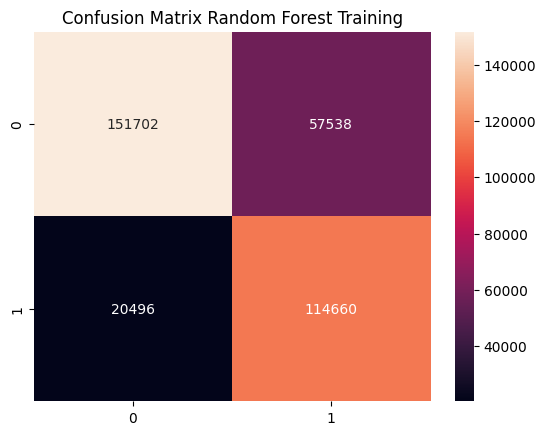

In [245]:
plot_confusion_matrix(train_labels, predict_RF_train, 'Confusion Matrix Random Forest Training')

False positives and False negatives are more imbalance than previous models...

In [247]:
rf_scores = get_scores(train_set, train_labels, [rf_model])
display(rf_scores)

,model,accuracy,precision,recall,f1
0,RandomForestClassifier,0.773418,0.665861,0.848353,0.74611


But F1 score in line with previous models!

This kind of model is very sensitive to the hyperparameter values. 

We will try a grid of hyperparameters search and see whats the best structure for this model

In [248]:
start = time.perf_counter()

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 2)]
#Max features selected
max_features = [int(x) for x in np.linspace(6, 10, num = 2)]
#Min sample leaf
min_samples_leaf = [int(x) for x in np.linspace(2, 6, num = 2)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

forest_classifier = RandomForestClassifier()

# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
rf_searchcv = RandomizedSearchCV(estimator = forest_classifier, param_distributions = random_grid, 
                               n_iter = 16, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# Fit
rf_searchcv.fit(train_set, train_labels)

end = time.perf_counter()

print("Tuning Random Forest Classifier spent {0:.2f} minutes".format((end-start)/60));
print("")
print("best hyperparameters: ".format(rf_searchcv.best_params_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END bootstrap=True, max_depth=2, max_features=10, min_samples_leaf=2; total time= 1.0min
[CV] END bootstrap=True, max_depth=10, max_features=10, min_samples_leaf=6; total time= 4.1min
[CV] END bootstrap=False, max_depth=10, max_features=6, min_samples_leaf=2; total time= 3.5min
[CV] END bootstrap=True, max_depth=2, max_features=10, min_samples_leaf=6; total time=  59.9s
[CV] END bootstrap=True, max_depth=10, max_features=10, min_samples_leaf=2; total time= 4.1min
[CV] END bootstrap=False, max_depth=10, max_features=6, min_samples_leaf=2; total time= 3.5min
[CV] END bootstrap=True, max_depth=2, max_features=10, min_samples_leaf=2; total time= 1.0min
[CV] END bootstrap=True, max_depth=10, max_features=10, min_samples_leaf=2; total time= 4.1min
[CV] END bootstrap=False, max_depth=10, max_features=6, min_samples_leaf=6; total time= 3.5min
[CV] END bootstrap=True, max_depth=2, max_features=10, min_samples_leaf=2; total time= 

New model with tuned hyperparameters

              precision    recall  f1-score   support

           0       0.92      0.94      0.93    172198
           1       0.94      0.92      0.93    172198

    accuracy                           0.93    344396
   macro avg       0.93      0.93      0.93    344396
weighted avg       0.93      0.93      0.93    344396



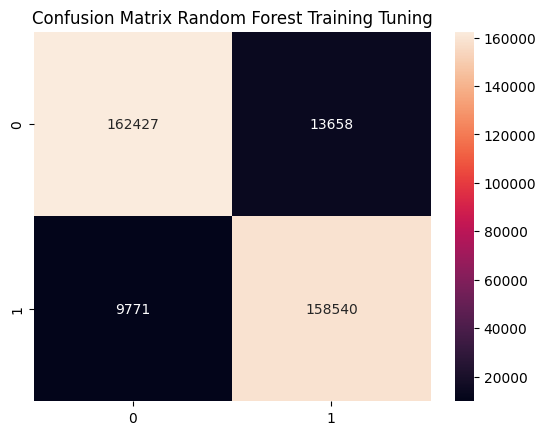

In [249]:
print(get_classification_report(rf_searchcv.best_estimator_, train_set, train_labels))

predict_RF_train_Robust = rf_searchcv.predict(train_set)
plot_confusion_matrix(train_labels, predict_RF_train_Robust, 'Confusion Matrix Random Forest Training Tuning')

Yes, we have a better confussion matrix.

Our errors are more balanced between False Positive and False Negatives.

And using the validation set:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     43050
           1       0.01      0.40      0.03        94

    accuracy                           0.94     43144
   macro avg       0.51      0.67      0.50     43144
weighted avg       1.00      0.94      0.97     43144



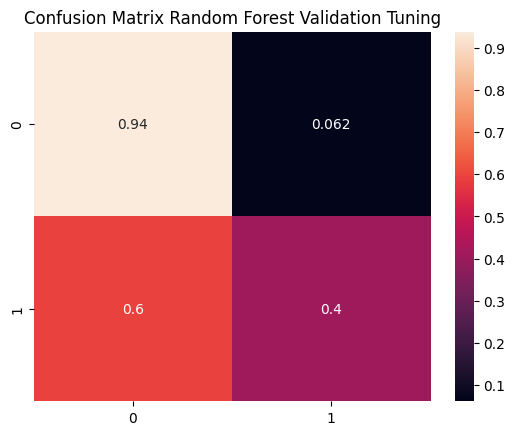

In [259]:
predict_RF_validation_Robust = rf_searchcv.predict(test_set)
print(get_classification_report(rf_searchcv.best_estimator_, test_set, test_labels))
plot_confusion_matrix_normalised(test_labels, predict_RF_validation_Robust, 'Confusion Matrix Random Forest Validation Tuning')

Feature importance based on mean decrease in impurity

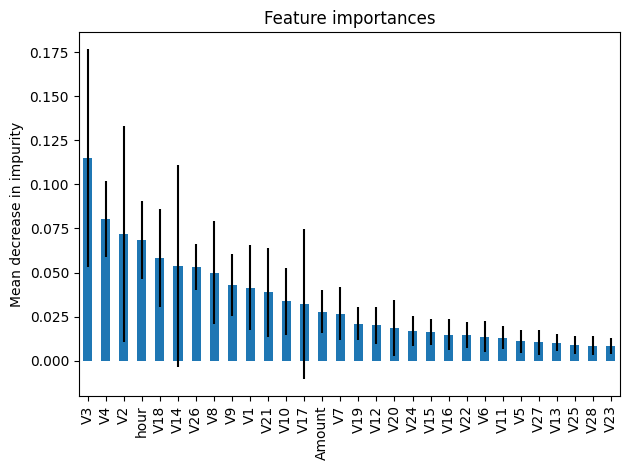

In [260]:
feature_names = np.array(train_set.columns)

importances = rf_searchcv.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_searchcv.best_estimator_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

FImportance = forest_importances.to_frame()
FImportance.columns = ["Importance"]
FImportance["std"]=std
FImportance = FImportance.sort_values(by="Importance", ascending=False)

fig, ax = plt.subplots()
FImportance["Importance"].plot.bar(yerr=FImportance["std"], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

## Decision Tree Classifier
We now use a grid search to tune hyperparameters for the decision tree classifier.

In [261]:
dt_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 50, 100],
    'min_samples_leaf': [1, 3, 5, 10],
}
dt_searchcv = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=dt_grid, verbose=5, cv=3, n_jobs=-1)
dt_searchcv.fit(train_set, train_labels)
display(dt_searchcv.best_estimator_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


DecisionTreeClassifier(criterion='entropy', max_depth=50, random_state=0)

We now test the model against our 'test' set (which has been split from our training set)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     43050
           1       0.02      0.17      0.04        94

    accuracy                           0.98     43144
   macro avg       0.51      0.58      0.51     43144
weighted avg       1.00      0.98      0.99     43144



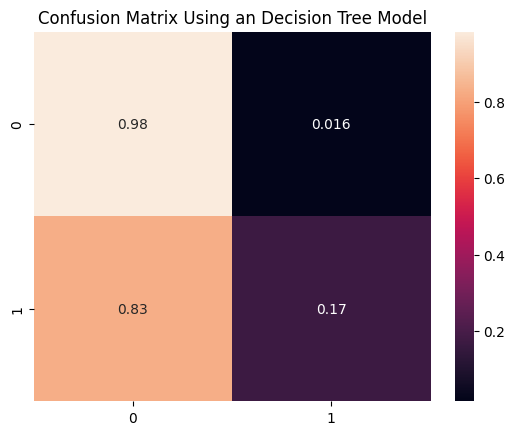

In [262]:
print(get_classification_report(dt_searchcv.best_estimator_, test_set, test_labels))
plot_confusion_matrix_normalised(test_labels, dt_searchcv.predict(test_set), 'Confusion Matrix Using an Decision Tree Model')

As we can see, this model has an ratherpoor accuracy when it comes to classifying fradulent transactions. 

## HistGradientBoostingClassifier

In [112]:
hgb_grid = {
    'learning_rate': [0.25, 0.5, 0.75],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_leaf_nodes': [25, 50, 75, 100],
    'max_depth': [5, 15, 25, 30],
}

hgb_searchcv = GridSearchCV(estimator=HistGradientBoostingClassifier(random_state=0), param_grid=hgb_grid, verbose=5, cv=3, n_jobs=-1)
hgb_searchcv.fit(train_set, train_labels)
print(hgb_searchcv.best_estimator_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
HistGradientBoostingClassifier(learning_rate=0.5, max_depth=25,
                               max_leaf_nodes=100, min_samples_leaf=5,
                               random_state=0)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43050
           1       0.31      0.20      0.25        94

    accuracy                           1.00     43144
   macro avg       0.65      0.60      0.62     43144
weighted avg       1.00      1.00      1.00     43144



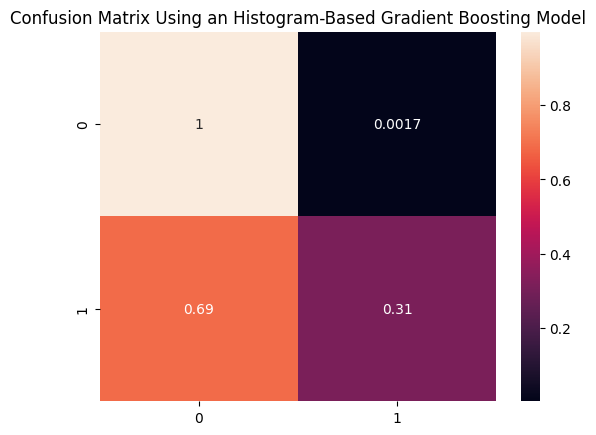

In [263]:
print(get_classification_report(hgb_searchcv.best_estimator_, test_set, test_labels))
plot_confusion_matrix_normalised(hgb_searchcv.predict(test_set), test_labels, 'Confusion Matrix Using an Histogram-Based Gradient Boosting Model')

## Model Evaluation
From the confusion matrices, we expected that our Random Forest Classifier would be the best model. To see if our results were expected, we tested our models against the test set. These results were submitted to Kaggle for the final scores (see report for results).

In [290]:
test_csv['Class'] = pd.Series()
final_test_set = pipeline.transform(test_csv)
final_test_set = final_test_set.drop(columns='Class')

final_comparisons = {}

for searchcv in [sgd_searchcv, lr_searchcv, rf_searchcv, dt_searchcv, hgb_searchcv]:
    final_predictions = {'id': test_csv['id'], 'Class' :searchcv.predict(final_test_set)}
    pd.DataFrame(searchcv.predict(final_test_set), columns=['Class']).join(test_csv['id']).set_index('id').to_csv(f'{type(searchcv.best_estimator_).__name__}.csv')